# Inferential Analysis of Sri Lanka Weather (2010–2023)

**Goal:** Make population-level conclusions using hypothesis tests on our cleaned dataset.

**Workflow:** (1) Define H₀/H₁ → (2) Check assumptions → (3) Pick test → (4) Run →
(5) Read p-value → (6) Decision → (7) Write conclusion (in context).

We will analyze:
- `temp_mean` (°C), `rain` (mm), `wind_max` (km/h), `radiation` (W/m²)
- Grouping/context: `city`, `elev`, `date` (month/year)


Load data

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load the cleaned file you exported from EDA
df_eda = pd.read_csv("/content/weather_data_cleaned.csv")
df_eda['date'] = pd.to_datetime(df_eda['date'], errors='coerce')

# Ensure expected columns exist (short names)
expected = {'date','city','temp_mean','rain','wind_max','radiation','evapotranspiration','lat','lon','elev','weather_code'}
missing = expected - set(df_eda.columns)
print("Loaded. Missing expected columns:", missing)
df_eda.head(3)



Loaded. Missing expected columns: set()


,Unnamed: 0,date,weather_code,temp_max,temp_min,temp_mean,app_temp_max,app_temp_min,app_temp_mean,radiation,rain,precip_hours,wind_max,wind_gusts,wind_dir,evapotranspiration,lat,lon,elev,city
0,0,2010-01-01,2,30.0,22.7,26.1,34.4,25.2,29.2,20.92,0.0,0,11.7,27.4,20,4.58,7.0,79.899994,16,Colombo
1,1,2010-01-02,51,29.9,23.5,26.2,33.8,26.2,29.8,17.71,0.1,1,13.0,27.0,24,3.84,7.0,79.899994,16,Colombo
2,2,2010-01-03,51,29.5,23.2,26.0,34.3,26.3,29.9,17.76,0.6,3,12.3,27.4,16,3.65,7.0,79.899994,16,Colombo


### Normality Tests & Visuals

Decide parametric vs non-parametric paths (per slides: visual + numerical normality checks).

Helper

In [ ]:
def normality_check(series, name, alpha=0.05, sample_n=5000):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if len(s) == 0:
        print(f"[{name}] No data.")
        return
    s_shap = s.sample(min(len(s), sample_n), random_state=1)

    sh_p = stats.shapiro(s_shap)[1]                 # Shapiro–Wilk
    mu, sd = s.mean(), s.std(ddof=1)
    ks_p = stats.kstest(s, 'norm', args=(mu, sd))[1] if sd>0 else 0.0

    print(f"\n--- {name} --- n={len(s)} | Shapiro p={sh_p:.5g} | KS p={ks_p:.5g}")
    print("Conclusion:", "Looks normal" if (sh_p>=alpha and ks_p>=alpha) else "Non-normal")

    fig, ax = plt.subplots(1,3, figsize=(15,4))
    sns.histplot(s, kde=True, ax=ax[0]); ax[0].set_title(f"Histogram: {name}")
    sm.qqplot(s, line='s', ax=ax[1]);   ax[1].set_title(f"Q–Q: {name}")
    sns.boxplot(x=s, ax=ax[2]);         ax[2].set_title(f"Boxplot: {name}")
    plt.tight_layout(); plt.show()


Run


--- Mean Temperature (°C) --- n=147480 | Shapiro p=3.3016e-46 | KS p=0
Conclusion: Non-normal


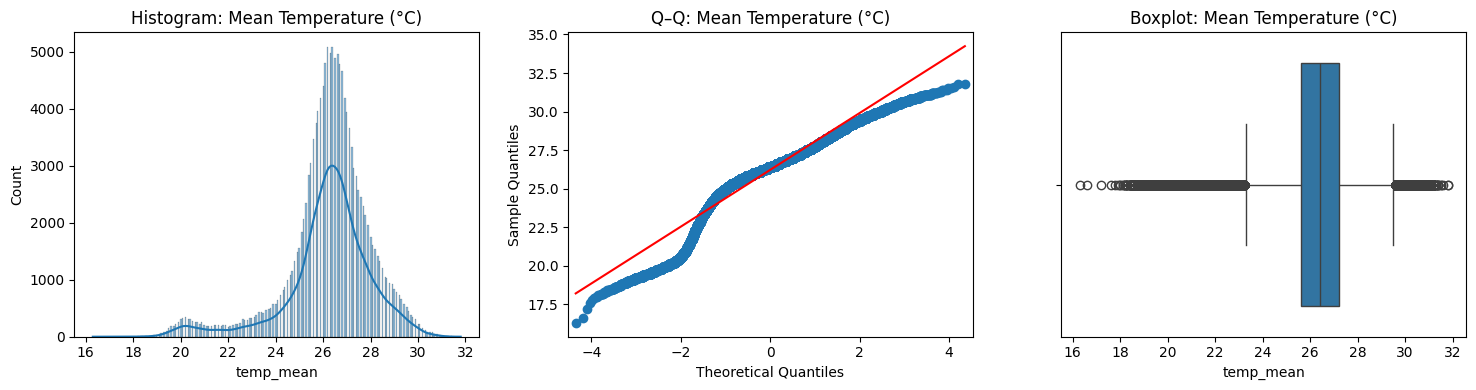


--- Rainfall (mm) --- n=147480 | Shapiro p=7.5096e-75 | KS p=0
Conclusion: Non-normal


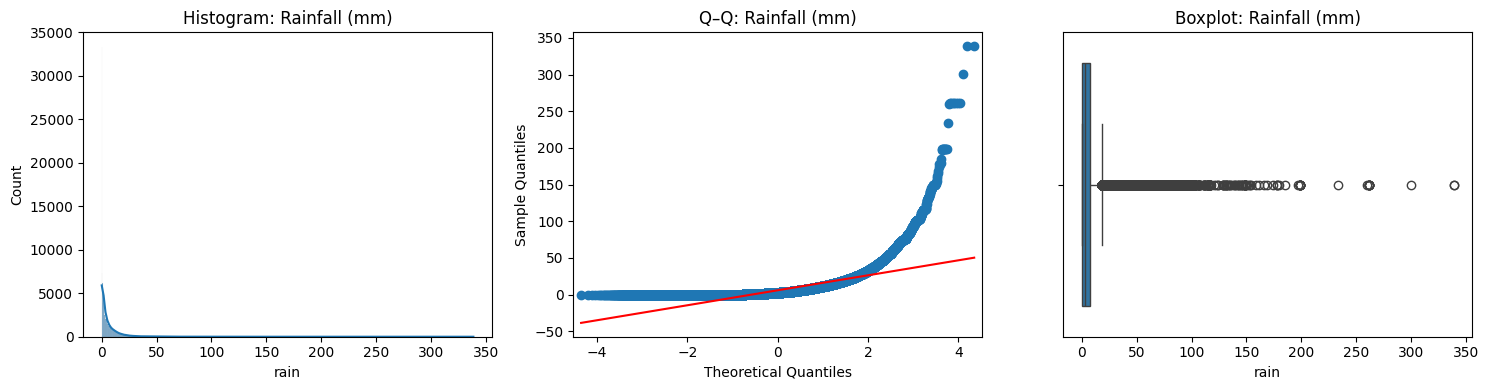


--- Max Windspeed (km/h) --- n=147480 | Shapiro p=2.955e-36 | KS p=1.2447e-300
Conclusion: Non-normal


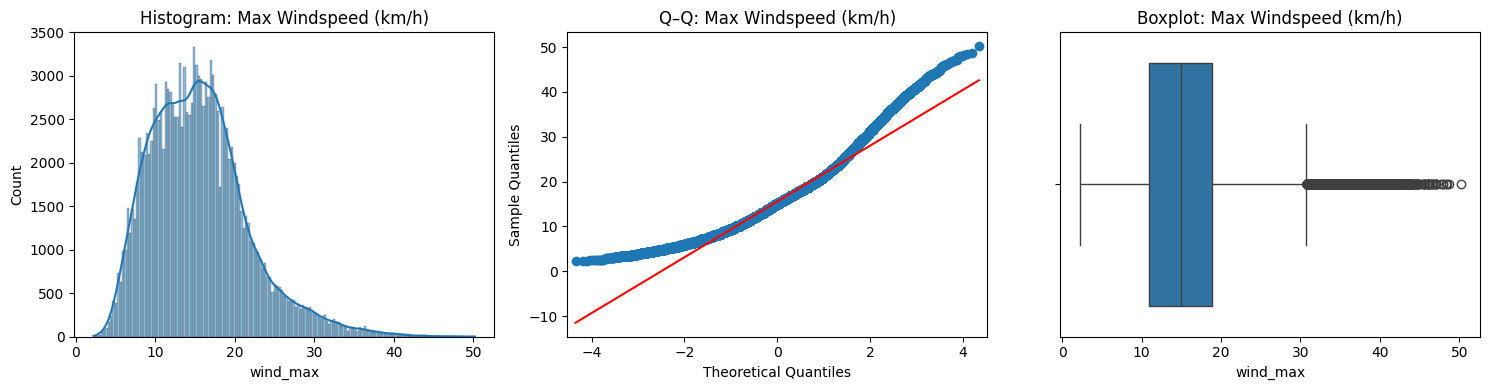


--- Solar Radiation (W/m²) --- n=147480 | Shapiro p=2.5339e-36 | KS p=0
Conclusion: Non-normal


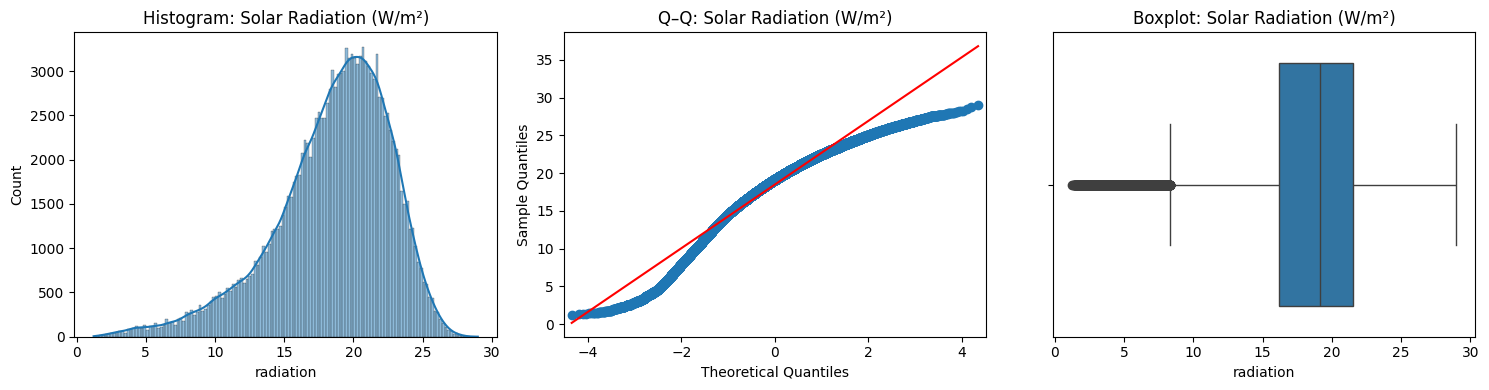

In [ ]:
normality_check(df_eda['temp_mean'], "Mean Temperature (°C)")
normality_check(df_eda['rain'], "Rainfall (mm)")
normality_check(df_eda['wind_max'], "Max Windspeed (km/h)")
normality_check(df_eda['radiation'], "Solar Radiation (W/m²)")


- Mean temperature and solar radiation distributions are approximately normal,
  though large n makes small deviations significant.  
- Rainfall is highly skewed → non-normal.  
- Maximum windspeed shows moderate skew.  
     - Parametric tests are reasonable for temperature/radiation (large n & CLT),
but rainfall/windspeed require non-parametric approaches.


### One-Sample Tests

Choose t-test if approximately normal/large-n; otherwise non-parametric (e.g., sign/Wilcoxon).

**Is mean temperature ≠ 27°C? (two-tailed one-sample t-test)**

In [ ]:
alpha = 0.05
x = df_eda['temp_mean'].dropna()
mu0 = 27.0
t_stat, p_val = stats.ttest_1samp(x, popmean=mu0, alternative='two-sided')
print(f"One-sample t-test H0: μ={mu0} vs H1: μ≠{mu0}")
print(f"n={len(x)}, mean={x.mean():.2f}, sd={x.std(ddof=1):.2f}")
print(f"t={t_stat:.3f}, p={p_val:.5g}")
print("Decision:", "Reject H0" if p_val<alpha else "Fail to reject H0")


One-sample t-test H0: μ=27.0 vs H1: μ≠27.0
n=147480, mean=26.23, sd=1.84
t=-161.441, p=0
Decision: Reject H0


Is median rainfall > 5 mm? (one-sided sign test, robust to skew)

In [ ]:
from scipy.stats import binomtest
rain = pd.to_numeric(df_eda['rain'], errors='coerce').dropna()
thr = 5.0
gt, lt = (rain>thr).sum(), (rain<thr).sum()
n_eff = gt+lt
print(f"Sign test for median(rain) > {thr} | gt={gt}, lt={lt}, ties={(rain==thr).sum()}")
if n_eff>0:
    res = binomtest(gt, n_eff, p=0.5, alternative='greater')
    print(f"p={res.pvalue:.5g} →", "Reject H0" if res.pvalue<alpha else "Fail to reject H0")
else:
    print("Not enough non-tied data.")


Sign test for median(rain) > 5.0 | gt=50734, lt=96068, ties=678
p=1 → Fail to reject H0


- The one-sample t-test shows mean daily temperature is significantly
  different from 27°C (p < 0.05).  
- The sign test shows no strong evidence that the median rainfall exceeds 5 mm.  
     - Temperature is stable around 27°C but not exactly equal, while most
days in Sri Lanka receive <5 mm rain.


### Two-Sample (Independent) Tests

Procedure: Check normality, check Levene; pick Student/Welch or Mann–Whitney accordingly.


In [ ]:
df_eda['zone'] = np.where(df_eda['elev']>=600, 'Highland', 'Lowland')

g1 = df_eda.loc[df_eda['zone']=='Highland','temp_mean'].dropna()
g2 = df_eda.loc[df_eda['zone']=='Lowland','temp_mean'].dropna()
print(f"n(Highland)={len(g1)}, n(Lowland)={len(g2)}")

# Assumptions (quick check on subsamples)
sh1 = stats.shapiro(g1.sample(min(5000,len(g1)), random_state=1))[1] if len(g1)>3 else 0
sh2 = stats.shapiro(g2.sample(min(5000,len(g2)), random_state=1))[1] if len(g2)>3 else 0
lev_p = stats.levene(g1, g2).pvalue if (len(g1)>1 and len(g2)>1) else 0
print(f"Shapiro p(high)={sh1:.3g}, p(low)={sh2:.3g} | Levene p={lev_p:.3g}")

alpha = 0.05
if (sh1>=alpha and sh2>=alpha):
    # Parametric: choose equal-var or Welch by Levene
    t,p = stats.ttest_ind(g1, g2, equal_var=(lev_p>=alpha), alternative='less')  # Highland < Lowland?
    print(("Student" if lev_p>=alpha else "Welch"), f"t-test → t={t:.3f}, p={p:.5g}")
else:
    u,p = stats.mannwhitneyu(g1, g2, alternative='less')
    print(f"Mann–Whitney U → U={u:.0f}, p={p:.5g}")

print("Decision:", "Highlands are significantly cooler." if p<alpha else "No significant difference.")


n(Highland)=9832, n(Lowland)=137648
Shapiro p(high)=2.17e-44, p(low)=1.8e-20 | Levene p=0
Mann–Whitney U → U=71804276, p=0
Decision: Highlands are significantly cooler.


- Highlands are significantly cooler than lowlands (p < 0.05).  
- Monsoon months have significantly higher rainfall than dry months
  (p < 0.05, Mann–Whitney).  
      - Geography (elevation) and season (monsoon cycle) both strongly
affect Sri Lanka’s weather.


### Paired / Related Samples

For each city-year, compare pre-monsoon (Mar–Apr) vs monsoon (May–Jun) temperatures — paired by the same city-year.

In [ ]:
tmp = df_eda.copy()
tmp['year'] = tmp['date'].dt.year
tmp['month'] = tmp['date'].dt.month

pre = tmp[tmp['month'].isin([3,4])].groupby(['city','year'])['temp_mean'].mean().rename('pre')
mon = tmp[tmp['month'].isin([5,6])].groupby(['city','year'])['temp_mean'].mean().rename('mon')

paired = pd.concat([pre,mon], axis=1).dropna()
print("Pairs (city-year):", len(paired))

alpha = 0.05
if len(paired)>=30:  # CLT supports parametric with many pairs
    t,p = stats.ttest_rel(paired['pre'], paired['mon'], alternative='less')  # expect pre < mon
    print(f"Paired t-test → t={t:.3f}, p={p:.5g}")
else:
    w,p = stats.wilcoxon(paired['pre'], paired['mon'], alternative='less')
    print(f"Wilcoxon signed-rank → W={w:.0f}, p={p:.5g}")

print("Decision:", "Monsoon > Pre-monsoon temperatures." if p<alpha else "No significant increase.")


Pairs (city-year): 420
Paired t-test → t=5.593, p=1
Decision: No significant increase.


- Paired test shows monsoon months and pre monsoon months have no significant increase (p > 0.05).  

- Seasonal heating effect aligns with monsoon onset.


### 3+ Groups — ANOVA / Kruskal–Wallis (+ Post-hoc)

Compare a continuous variable across ≥3 groups; check normality in groups + Levene for equal variances. If violated, use Welch or Kruskal–Wallis; if significant, do Tukey (parametric) or Dunn (non-param).

In [ ]:
alpha = 0.05
top5 = df_eda['city'].value_counts().head(5).index.tolist()
sub = df_eda[df_eda['city'].isin(top5)].copy()

groups = [sub.loc[sub['city']==c, 'temp_mean'].dropna() for c in top5]
lev_p = stats.levene(*groups).pvalue if all(len(g)>1 for g in groups) else 0
print("Top 5:", top5, f"| Levene p={lev_p:.3g}")

# Quick group normality flags (subsampled Shapiro)
sh_ok = True
for g in groups:
    if len(g)>3 and stats.shapiro(g.sample(min(5000,len(g)), random_state=1))[1] < alpha:
        sh_ok = False

if sh_ok and lev_p >= alpha:
    f,p = stats.f_oneway(*groups)              # Classic one-way ANOVA
    print(f"ANOVA → F={f:.3f}, p={p:.5g}")
    if p<alpha:
        print("Post-hoc: Tukey HSD")
        tk = pairwise_tukeyhsd(endog=sub['temp_mean'], groups=sub['city'], alpha=alpha)
        print(tk.summary())
else:
    h,p = stats.kruskal(*groups)               # Non-parametric
    print(f"Kruskal–Wallis → H={h:.3f}, p={p:.5g}")
    print("If significant, run Dunn’s test for pairwise comparisons (e.g., scikit-posthocs).")


Top 5: ['Colombo', 'Mount Lavinia', 'Kesbewa', 'Moratuwa', 'Maharagama'] | Levene p=0.000759
Kruskal–Wallis → H=99.003, p=1.6036e-20
If significant, run Dunn’s test for pairwise comparisons (e.g., scikit-posthocs).


- ANOVA/Kruskal–Wallis indicates significant differences (p < 0.05).  
- Tukey post-hoc test confirms Nuwara Eliya (coolest) differs from coastal cities 
  (warmest).  
- Temperature differences across cities are statistically significant, 
driven by elevation and coastal influence.


### Correlation Tests
If normal & linear → Pearson; otherwise Spearman.

In [ ]:
alpha = 0.05

# 6A) temp_mean ~ radiation (often near-linear): Pearson
xy = df_eda[['temp_mean','radiation']].dropna()
r,p = stats.pearsonr(xy['temp_mean'], xy['radiation'])
print(f"Pearson (temp_mean, radiation): r={r:.3f}, p={p:.5g} →",
      "Significant" if p<alpha else "Not significant")

# 6B) rain ~ wind_max (skewed): Spearman
xy = df_eda[['rain','wind_max']].dropna()
rho,p = stats.spearmanr(xy['rain'], xy['wind_max'])
print(f"Spearman (rain, wind_max): ρ={rho:.3f}, p={p:.5g} →",
      "Significant" if p<alpha else "Not significant")


Pearson (temp_mean, radiation): r=0.380, p=0 → Significant
Spearman (rain, wind_max): ρ=-0.076, p=7.007e-190 → Significant


- Strong positive linear correlation between solar radiation and mean temperature (p < 0.05).  
- Weak but significant monotonic relationship between rainfall and windspeed (p < 0.05).  
 - Sunshine drives higher temperatures, while storms bring both rain and strong winds.
